In [1]:
from koopman_probabilistic import *
import vanilla_benchmark

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import norm, skewnorm, skew

# Pinball Loss

In [2]:
def normal_pinball_loss(data, mus, sigmas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = norm.ppf(q, loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [3]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [4]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

# Testing Normal Distribution Assumption

In [5]:
min_train_start = 9 * 365 * 24 + 2 * 24  # 2 leap years in from 2005 to 2014
train_starts = np.linspace(min_train_start, min_train_start + 24 * 365 - 24, 12, endpoint=False).astype(int)

In [6]:
print(list(train_starts))

[78888, 79616, 80344, 81072, 81800, 82528, 83256, 83984, 84712, 85440, 86168, 86896]


In [7]:
zone_name = "ISONE CA"
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
now

'2021-03-03_08.23.07.134402'

In [ ]:
vanilla_losses = []
for train_start in train_starts:
    vanilla_losses.append(vanilla_benchmark.get_lossesGEFCom(start=train_start, zones=[zone_name], plot=True)[zone_name])

In [ ]:
for loss in vanilla_losses:
    print(np.round(loss, 1), end="\t")

In [ ]:
import json

with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json") as f:
    all_data = json.loads(f.read())
    
data = np.transpose(np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64))

In [15]:
x_original = data
mean = np.mean(data, axis=0)
rnge = np.max(data, axis=0) - np.min(data, axis=0)
data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
print("data", data.shape)

data (96408, 1)


TRAIN START: 78888 = 2014-01-01 00:00:00
x (9504, 1)
xt (8760, 1)


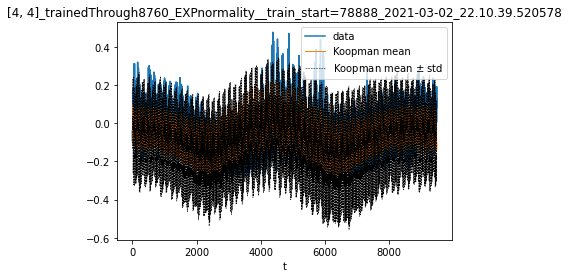

actual overall mean: 0  predicted mean: -0.07759361


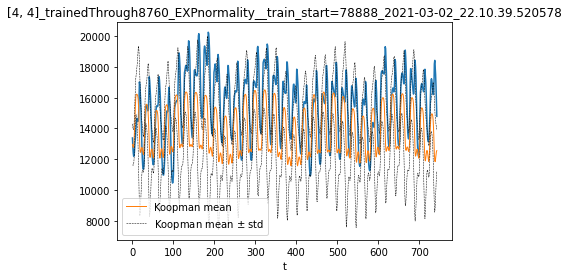

pinball_loss: 750.3394210914113
-51.294306455078996% performance relative to vanilla benchmark





TRAIN START: 80344 = 2014-03-02 00:00:00
x (9504, 1)
xt (8760, 1)


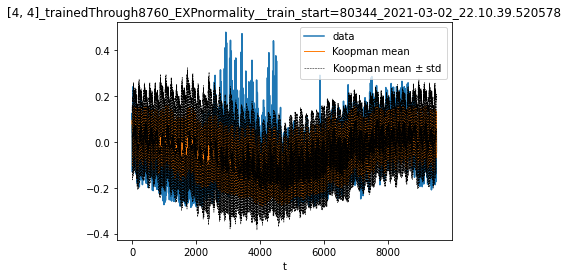

actual overall mean: 0  predicted mean: -0.012523631


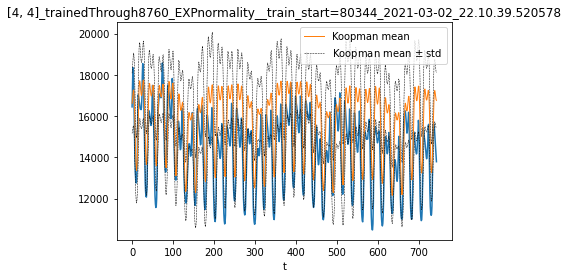

pinball_loss: 541.6132298599863
-57.702832152185415% performance relative to vanilla benchmark





TRAIN START: 81800 = 2014-05-02 00:00:00
x (9504, 1)
xt (8760, 1)


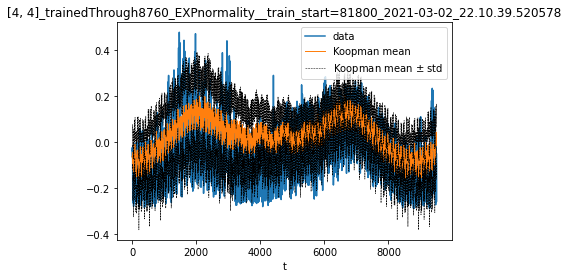

actual overall mean: 0  predicted mean: 0.026476936


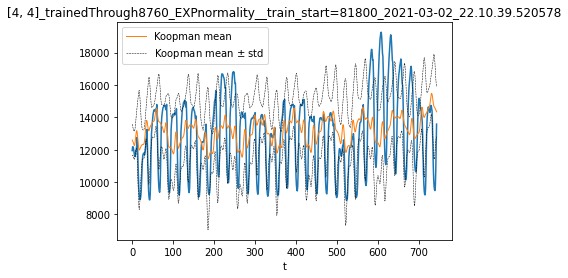

pinball_loss: 689.0690938411386
-43.64258746848788% performance relative to vanilla benchmark





TRAIN START: 83256 = 2014-07-02 00:00:00
x (9504, 1)
xt (8760, 1)


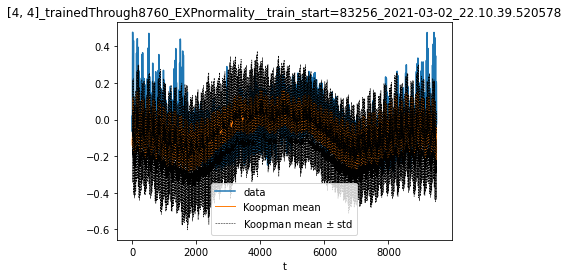

actual overall mean: 0  predicted mean: -0.06798596


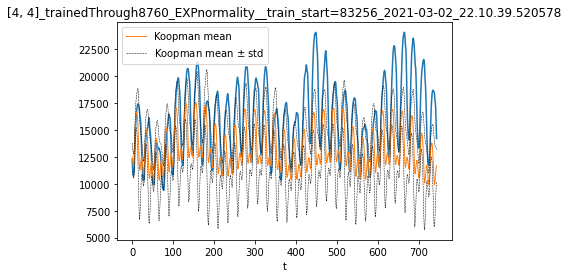

pinball_loss: 1211.4070868652782
-58.774719414403044% performance relative to vanilla benchmark





TRAIN START: 84712 = 2014-08-31 00:00:00
x (9504, 1)
xt (8760, 1)


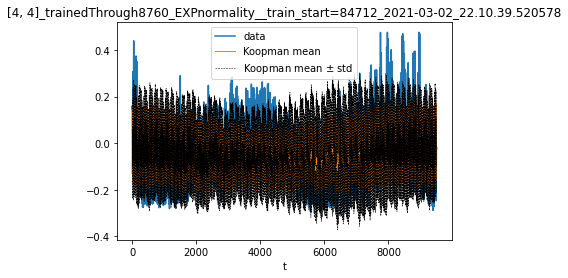

actual overall mean: 0  predicted mean: -0.008900003


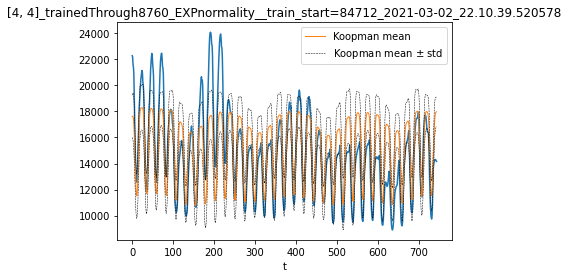

pinball_loss: 649.5728735880574
-9.43692005086174% performance relative to vanilla benchmark





TRAIN START: 86168 = 2014-10-31 00:00:00
x (9504, 1)
xt (8760, 1)


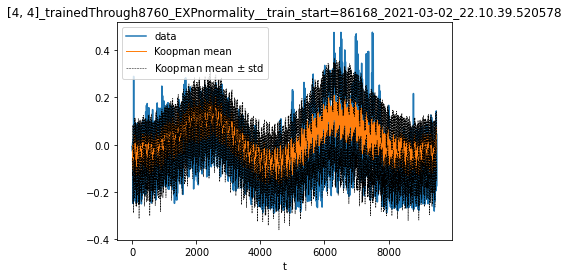

actual overall mean: 0  predicted mean: 0.010237921


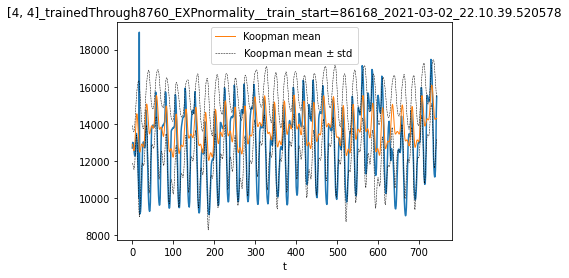

pinball_loss: 551.4659255292073
-28.706312097455356% performance relative to vanilla benchmark







In [26]:
%matplotlib inline
mu_hats = []
sigma_hats = []
z_scores_list = []
test_z_scores_list = []
losses = []
relative_perf = []

for month, train_start in list(enumerate(train_starts))[::2]:
    print("TRAIN START:", train_start, "=", all_data[zone_name]["Date"][train_start])
    
    train_through = 365 * 24
    delay = 0  # 52 * 24
    predict_through = train_through + 24 * 31 + delay  
    x = data[train_start:]
    x = x[:predict_through]
    xt = x[:train_through]

    data_name = "EXPnormality_" + f"_train_start={train_start}_" + now
    
    # num_freqs = [4, 4, 4]
    num_freqs = [4, 4]
    num_fourier = 4
    mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
    sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
    # alpha_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}alpha.npy"
    print("x", x.shape)
    print("xt", xt.shape)
    
    
    ### TRAIN ###
    model = AlternatingNormalNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=512)
    k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)
    
    k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.25])
    
    k.fit(xt, iterations=200, interval=10, verbose=False, cutoff=0, weight_decay=1e-10000, lr_theta=1e-3, lr_omega=0, num_slices=None);
    k.fit(xt, iterations=1000, interval=10, verbose=False, cutoff=0, weight_decay=1e-10000, lr_theta=1e-5, lr_omega=0, num_slices=None);
    
    
    ### FORECAST ###
    params = k.predict(predict_through)
    # mu_hat, sigma_hat, a_hat = params
    # np.save(mu_file, mu_hat)
    # np.save(sigma_file, sigma_hat)
    # np.save(alpha_file, a_hat)
    params = k.predict(predict_through)
    mu_hats.append(params[0])
    sigma_hats.append(params[1])
    np.save(mu_file, mu_hats[-1])
    np.save(sigma_file, sigma_hats[-1])
    
    mean_hat = model.mean(params)
    std_hat = model.std(params)
    
    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    # plt.plot(mu_vec[slc:], label="real mu")
    # plt.plot(mu_hat[slc:, 0], label="koopman mu")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(sigma_vec[slc:], label="real sigma")
    #     plt.plot(3*sigma_hat[:, dim], label="koopman $3\sigma$", linewidth=0.7)
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()
    
    ### ANALYTICS ###
    print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))
    
    z_scores_list.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores_list.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])
    # z_scores = ((x[train_through:predict_through] - mean_hat[train_through:]) / std_hat[train_through:])[:8760, 0]
    
    ### PERFORMANCE ###
    test_start = train_through + delay
    # Skew Normal Distribution rescaling
    # sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
    # delta = ah / (1 + ah ** 2) ** 0.5
    # muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    # muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    # sigh = sigh * rnge
    # mean_hat = model.mean([muh, sigh, ah])
    # std_hat = model.std([muh, sigh, ah])

    # Normal Distribution
    sigh = sigma_hats[-1][test_start: predict_through] * rnge
    muh = mu_hats[-1][test_start: predict_through] * rnge + mean
    mean_hat = model.mean([muh, sigh])
    std_hat = model.std([muh, sigh])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()
    
    loss = normal_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh)[0]
    relative = (1 - loss/vanilla_losses[month]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perf.append(relative)
    
%matplotlib notebook

In [39]:
for loss in losses:
    print(np.round(loss, 1), end="\t")
print("\nrelative")
month = 0
for loss in losses:
    print(np.round((1 - loss/vanilla_losses[month]) * 100, 1), end="%\t")
    month += 2

750.3	541.6	689.1	1211.4	649.6	551.5	relative
-51.3%	-57.7%	-43.6%	-58.8%	-9.4%	-28.7%	

mean of z-scores in month 0: 0.30067664481156997 std of z-scores: 1.0176381912078611
mean of z-scores in month 1: -0.04065703545542394 std of z-scores: 1.1238445975965878
mean of z-scores in month 2: -0.24736849924484391 std of z-scores: 0.9915275693276596
mean of z-scores in month 3: 0.2002223690619696 std of z-scores: 1.0415431318615385
mean of z-scores in month 4: -0.0362616793142677 std of z-scores: 1.0868251872700914
mean of z-scores in month 5: -0.02929543040213687 std of z-scores: 1.0145037809253785


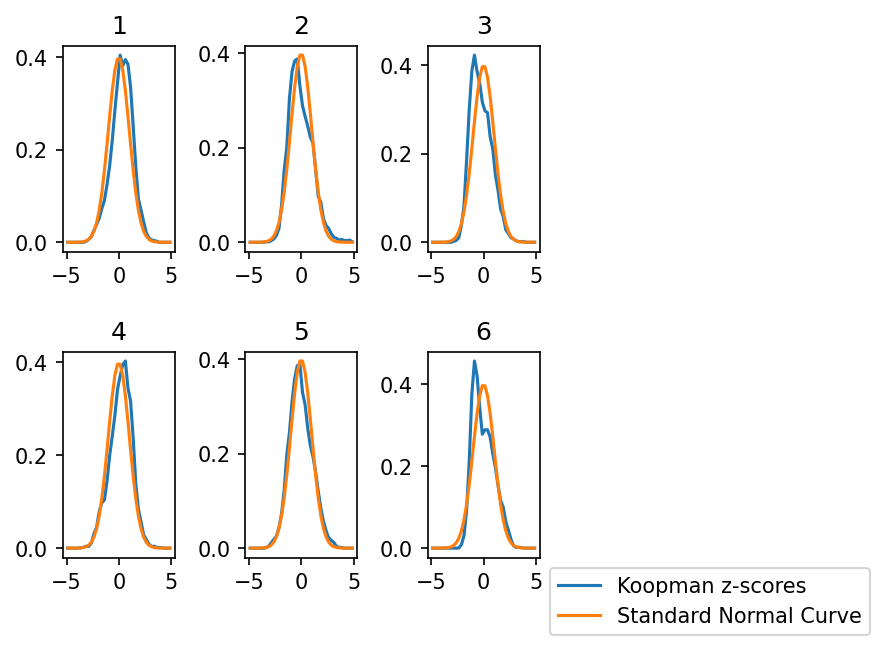

In [33]:
%matplotlib inline
plt.subplots(dpi=150, figsize=(6, 8))
for month, z_scores in enumerate(z_scores_list):
    z_hist, bin_edges = np.histogram(z_scores, bins=40, range=(-5, 5), density=True)
    z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
    print(f"mean of z-scores in month {month}:", np.mean(z_scores), "std of z-scores:", np.std(z_scores))
    
    plt.subplot(4, 3, month + 1)
    plt.plot(z_axis, z_hist, label="Koopman z-scores")
    plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
    plt.title(str(month + 1))
#     plt.xlabel("z")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()

mean of z-scores in month 0: 0.6835940084437583 std of z-scores: 0.8429678050975068
mean of z-scores in month 1: -0.8228519988277956 std of z-scores: 0.6263193599076816
mean of z-scores in month 2: 0.027491920932309847 std of z-scores: 1.1317057307004417
mean of z-scores in month 3: 1.025486695717216 std of z-scores: 1.1052894520301755
mean of z-scores in month 4: -0.26491575778772636 std of z-scores: 1.2861316572239951
mean of z-scores in month 5: -0.3188211016718748 std of z-scores: 0.8775023419709392


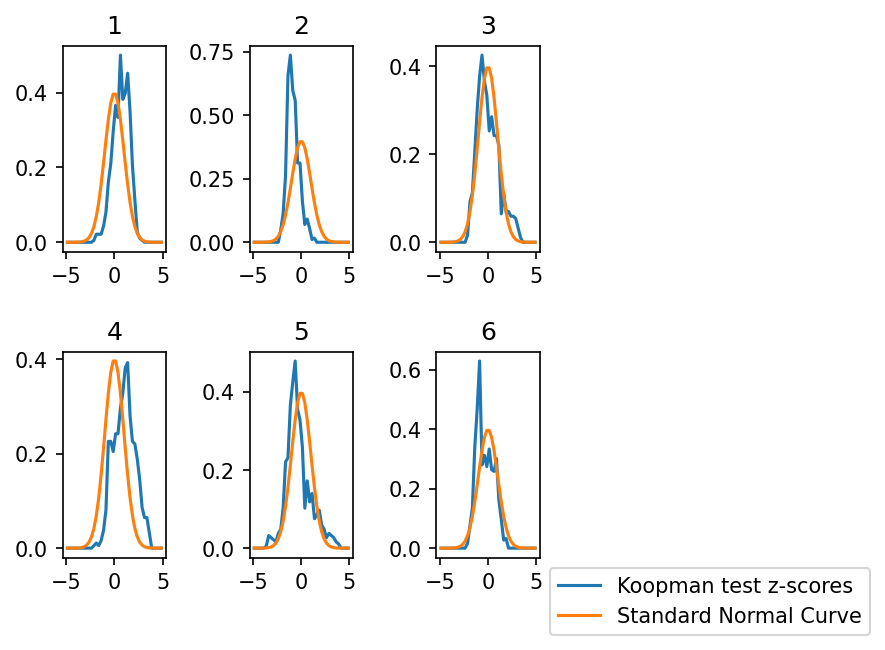

In [35]:
%matplotlib inline
plt.subplots(dpi=150, figsize=(6, 8))
for month, z_scores in enumerate(test_z_scores_list):
    z_hist, bin_edges = np.histogram(z_scores, bins=40, range=(-5, 5), density=True)
    z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
    print(f"mean of z-scores in month {month}:", np.mean(z_scores), "std of z-scores:", np.std(z_scores))
    
    plt.subplot(4, 3, month + 1)
    plt.plot(z_axis, z_hist, label="Koopman test z-scores")
    plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
    plt.title(str(month + 1))
#     plt.xlabel("z")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()

In [34]:
for z_scores in z_scores_list:
    print(np.round(np.mean(z_scores), 2), end="\t")
print()
for z_scores in z_scores_list:
    print(np.round(np.std(z_scores), 2), end="\t")
print()
for z_scores in z_scores_list:
    print(np.round(skew(z_scores)[0], 2), end="\t")
print("\ntest")
for z_scores in test_z_scores_list:
    print(np.round(np.mean(z_scores), 2), end="\t")
print()
for z_scores in test_z_scores_list:
    print(np.round(np.std(z_scores), 2), end="\t")
print()
for z_scores in test_z_scores_list:
    print(np.round(skew(z_scores)[0], 2), end="\t")

0.3	-0.04	-0.25	0.2	-0.04	-0.03	
1.02	1.12	0.99	1.04	1.09	1.01	
-0.25	0.68	0.49	-0.23	0.29	0.51	test
0.68	-0.82	0.03	1.03	-0.26	-0.32	
0.84	0.63	1.13	1.11	1.29	0.88	
-0.38	0.69	0.67	0.07	0.66	0.33	

In [13]:
train_through = 365 * 24
train_start = 9 * 365 * 24 + 2 * 24  # 2 leap years in from 2005 to 2014
delay = 0  # 52 * 24
predict_through = train_through + 24 * 31 + delay  
x = data[train_start:]
x = x[:predict_through]
xt = x[:train_through]

data_name = "EXPnormality_" + zone_name + f"_train_start={train_start}"

# num_freqs = [4, 4, 4]
num_freqs = [4, 4]
num_fourier = 4
mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
# alpha_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}alpha.npy"
print("x", x.shape)
print("xt", xt.shape)

x (9504, 1)
xt (8760, 1)


In [18]:
model = AlternatingNormalNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=512)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [19]:
k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.25])

tensor([0.2618, 0.0374, 0.0086, 0.0007])

In [35]:
k.fit(xt, iterations=1000, interval=10, verbose=True, cutoff=0, weight_decay=1e-10000, lr_theta=3e-6, lr_omega=0, num_slices=None);

Iteration  0
tensor([  24.0000,  168.0000,  730.4999, 8823.1260,   24.0000,  168.0000,
         730.4999, 8795.8389])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8823.1260,   24.0000,  168.0000,
         730.4999, 8795.8389], grad_fn=<MulBackward0>)
Loss:  -1.5405991136369903
Iteration  1
tensor([  24.0000,  168.0000,  730.4999, 8823.1260,   24.0000,  168.0000,
         730.4999, 8795.8389])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8823.1260,   24.0000,  168.0000,
         730.4999, 8795.8389], grad_fn=<MulBackward0>)
Loss:  -1.6216715630826084
Iteration  2
tensor([  24.0000,  168.0000,  730.4999, 8823.1260,   24.0000,  168.0000,
         730.4999, 8795.8389])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8823.1260,   24.0000,  168.0000,
         730.4999, 8795.8389], grad_fn=<MulBackward0>)
Loss:  -1.6488026513078782
Iteration  3
tensor([  24.0000,  168.0000,  730.4999, 8823.1260,   24.0000,  168.0000,
         730.4999, 8795.8389])
Set

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8823.9629,   24.0000,  168.0000,
         730.4999, 8796.5312], grad_fn=<MulBackward0>)
Loss:  -1.7326384442132043
Iteration  29
tensor([  24.0000,  168.0000,  730.4999, 8823.9629,   24.0000,  168.0000,
         730.4999, 8796.5312])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8824.0225,   24.0000,  168.0000,
         730.4999, 8796.5811], grad_fn=<MulBackward0>)
Loss:  -1.7339923462343767
Iteration  30
tensor([  24.0000,  168.0000,  730.4999, 8824.0225,   24.0000,  168.0000,
         730.4999, 8796.5811])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8824.0801,   24.0000,  168.0000,
         730.4999, 8796.6309], grad_fn=<MulBackward0>)
Loss:  -1.7352987119163983
Iteration  31
tensor([  24.0000,  168.0000,  730.4999, 8824.0801,   24.0000,  168.0000,
         730.4999, 8796.6309])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8824.1367,   24.0000,  168.0000,
         730.4999, 8796.6

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8825.5752,   24.0000,  168.0000,
         730.4999, 8797.8145], grad_fn=<MulBackward0>)
Loss:  -1.7582902897951083
Iteration  57
tensor([  24.0000,  168.0000,  730.4999, 8825.5752,   24.0000,  168.0000,
         730.4999, 8797.8145])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8825.6318,   24.0000,  168.0000,
         730.4999, 8797.8545], grad_fn=<MulBackward0>)
Loss:  -1.7588898487675992
Iteration  58
tensor([  24.0000,  168.0000,  730.4999, 8825.6318,   24.0000,  168.0000,
         730.4999, 8797.8545])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8825.6885,   24.0000,  168.0000,
         730.4999, 8797.8936], grad_fn=<MulBackward0>)
Loss:  -1.7594750168920728
Iteration  59
tensor([  24.0000,  168.0000,  730.4999, 8825.6885,   24.0000,  168.0000,
         730.4999, 8797.8936])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8825.7461,   24.0000,  168.0000,
         730.4999, 8797.9

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8827.1592,   24.0000,  168.0000,
         730.4999, 8798.9004], grad_fn=<MulBackward0>)
Loss:  -1.7707991754584067
Iteration  85
tensor([  24.0000,  168.0000,  730.4999, 8827.1592,   24.0000,  168.0000,
         730.4999, 8798.9004])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8827.2158,   24.0000,  168.0000,
         730.4999, 8798.9375], grad_fn=<MulBackward0>)
Loss:  -1.7711214280155751
Iteration  86
tensor([  24.0000,  168.0000,  730.4999, 8827.2158,   24.0000,  168.0000,
         730.4999, 8798.9375])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8827.2715,   24.0000,  168.0000,
         730.4999, 8798.9756], grad_fn=<MulBackward0>)
Loss:  -1.7714360360817571
Iteration  87
tensor([  24.0000,  168.0000,  730.4999, 8827.2715,   24.0000,  168.0000,
         730.4999, 8798.9756])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8827.3262,   24.0000,  168.0000,
         730.4999, 8799.0

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8828.6826,   24.0000,  168.0000,
         730.4999, 8799.8701], grad_fn=<MulBackward0>)
Loss:  -1.7778230830508346
Iteration  113
tensor([  24.0000,  168.0000,  730.4999, 8828.6826,   24.0000,  168.0000,
         730.4999, 8799.8701])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8828.7373,   24.0000,  168.0000,
         730.4999, 8799.8994], grad_fn=<MulBackward0>)
Loss:  -1.7780133269415048
Iteration  114
tensor([  24.0000,  168.0000,  730.4999, 8828.7373,   24.0000,  168.0000,
         730.4999, 8799.8994])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8828.7910,   24.0000,  168.0000,
         730.4999, 8799.9297], grad_fn=<MulBackward0>)
Loss:  -1.7782006333094982
Iteration  115
tensor([  24.0000,  168.0000,  730.4999, 8828.7910,   24.0000,  168.0000,
         730.4999, 8799.9297])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8828.8438,   24.0000,  168.0000,
         730.4999, 879

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8830.2012,   24.0000,  168.0000,
         730.4999, 8800.6797], grad_fn=<MulBackward0>)
Loss:  -1.782146667163112
Iteration  141
tensor([  24.0000,  168.0000,  730.4999, 8830.2012,   24.0000,  168.0000,
         730.4999, 8800.6797])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8830.2559,   24.0000,  168.0000,
         730.4999, 8800.7061], grad_fn=<MulBackward0>)
Loss:  -1.7822693430058336
Iteration  142
tensor([  24.0000,  168.0000,  730.4999, 8830.2559,   24.0000,  168.0000,
         730.4999, 8800.7061])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8830.3096,   24.0000,  168.0000,
         730.4999, 8800.7324], grad_fn=<MulBackward0>)
Loss:  -1.782390395513131
Iteration  143
tensor([  24.0000,  168.0000,  730.4999, 8830.3096,   24.0000,  168.0000,
         730.4999, 8800.7324])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8830.3633,   24.0000,  168.0000,
         730.4999, 8800.

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8831.7100,   24.0000,  168.0000,
         730.4999, 8801.4248], grad_fn=<MulBackward0>)
Loss:  -1.7850142434561285
Iteration  169
tensor([  24.0000,  168.0000,  730.4999, 8831.7100,   24.0000,  168.0000,
         730.4999, 8801.4248])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8831.7646,   24.0000,  168.0000,
         730.4999, 8801.4521], grad_fn=<MulBackward0>)
Loss:  -1.785098449273026
Iteration  170
tensor([  24.0000,  168.0000,  730.4999, 8831.7646,   24.0000,  168.0000,
         730.4999, 8801.4521])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8831.8184,   24.0000,  168.0000,
         730.4999, 8801.4785], grad_fn=<MulBackward0>)
Loss:  -1.7851816809826095
Iteration  171
tensor([  24.0000,  168.0000,  730.4999, 8831.8184,   24.0000,  168.0000,
         730.4999, 8801.4785])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8831.8721,   24.0000,  168.0000,
         730.4999, 8801

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8833.2314,   24.0000,  168.0000,
         730.4999, 8802.1416], grad_fn=<MulBackward0>)
Loss:  -1.7870376586825263
Iteration  197
tensor([  24.0000,  168.0000,  730.4999, 8833.2314,   24.0000,  168.0000,
         730.4999, 8802.1416])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8833.2861,   24.0000,  168.0000,
         730.4999, 8802.1670], grad_fn=<MulBackward0>)
Loss:  -1.7870992100135472
Iteration  198
tensor([  24.0000,  168.0000,  730.4999, 8833.2861,   24.0000,  168.0000,
         730.4999, 8802.1670])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8833.3408,   24.0000,  168.0000,
         730.4999, 8802.1914], grad_fn=<MulBackward0>)
Loss:  -1.7871596058444985
Iteration  199
tensor([  24.0000,  168.0000,  730.4999, 8833.3408,   24.0000,  168.0000,
         730.4999, 8802.1914])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8833.3965,   24.0000,  168.0000,
         730.4999, 880

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8834.7598,   24.0000,  168.0000,
         730.4999, 8802.8193], grad_fn=<MulBackward0>)
Loss:  -1.7885423709801533
Iteration  225
tensor([  24.0000,  168.0000,  730.4999, 8834.7598,   24.0000,  168.0000,
         730.4999, 8802.8193])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8834.8135,   24.0000,  168.0000,
         730.4999, 8802.8428], grad_fn=<MulBackward0>)
Loss:  -1.7885890617389293
Iteration  226
tensor([  24.0000,  168.0000,  730.4999, 8834.8135,   24.0000,  168.0000,
         730.4999, 8802.8428])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8834.8691,   24.0000,  168.0000,
         730.4999, 8802.8652], grad_fn=<MulBackward0>)
Loss:  -1.7886352967315535
Iteration  227
tensor([  24.0000,  168.0000,  730.4999, 8834.8691,   24.0000,  168.0000,
         730.4999, 8802.8652])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8834.9238,   24.0000,  168.0000,
         730.4999, 880

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8836.3115,   24.0000,  168.0000,
         730.4999, 8803.4561], grad_fn=<MulBackward0>)
Loss:  -1.7897150424333619
Iteration  253
tensor([  24.0000,  168.0000,  730.4999, 8836.3115,   24.0000,  168.0000,
         730.4999, 8803.4561])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8836.3682,   24.0000,  168.0000,
         730.4999, 8803.4785], grad_fn=<MulBackward0>)
Loss:  -1.7897525106651222
Iteration  254
tensor([  24.0000,  168.0000,  730.4999, 8836.3682,   24.0000,  168.0000,
         730.4999, 8803.4785])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8836.4229,   24.0000,  168.0000,
         730.4999, 8803.5010], grad_fn=<MulBackward0>)
Loss:  -1.7897891665958063
Iteration  255
tensor([  24.0000,  168.0000,  730.4999, 8836.4229,   24.0000,  168.0000,
         730.4999, 8803.5010])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8836.4785,   24.0000,  168.0000,
         730.4999, 880

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8837.8721,   24.0000,  168.0000,
         730.4999, 8804.0732], grad_fn=<MulBackward0>)
Loss:  -1.7906663512424783
Iteration  281
tensor([  24.0000,  168.0000,  730.4999, 8837.8721,   24.0000,  168.0000,
         730.4999, 8804.0732])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8837.9268,   24.0000,  168.0000,
         730.4999, 8804.0947], grad_fn=<MulBackward0>)
Loss:  -1.7906972748868228
Iteration  282
tensor([  24.0000,  168.0000,  730.4999, 8837.9268,   24.0000,  168.0000,
         730.4999, 8804.0947])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8837.9834,   24.0000,  168.0000,
         730.4999, 8804.1162], grad_fn=<MulBackward0>)
Loss:  -1.790727779153543
Iteration  283
tensor([  24.0000,  168.0000,  730.4999, 8837.9834,   24.0000,  168.0000,
         730.4999, 8804.1162])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8838.0391,   24.0000,  168.0000,
         730.4999, 8804

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8839.4365,   24.0000,  168.0000,
         730.4999, 8804.6748], grad_fn=<MulBackward0>)
Loss:  -1.7914656056126637
Iteration  309
tensor([  24.0000,  168.0000,  730.4999, 8839.4365,   24.0000,  168.0000,
         730.4999, 8804.6748])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8839.4922,   24.0000,  168.0000,
         730.4999, 8804.6953], grad_fn=<MulBackward0>)
Loss:  -1.7914919335161195
Iteration  310
tensor([  24.0000,  168.0000,  730.4999, 8839.4922,   24.0000,  168.0000,
         730.4999, 8804.6953])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8839.5488,   24.0000,  168.0000,
         730.4999, 8804.7168], grad_fn=<MulBackward0>)
Loss:  -1.791518230554625
Iteration  311
tensor([  24.0000,  168.0000,  730.4999, 8839.5488,   24.0000,  168.0000,
         730.4999, 8804.7168])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8839.6055,   24.0000,  168.0000,
         730.4999, 8804

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8841.0176,   24.0000,  168.0000,
         730.4999, 8805.2568], grad_fn=<MulBackward0>)
Loss:  -1.7921584496959593
Iteration  337
tensor([  24.0000,  168.0000,  730.4999, 8841.0176,   24.0000,  168.0000,
         730.4999, 8805.2568])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8841.0742,   24.0000,  168.0000,
         730.4999, 8805.2773], grad_fn=<MulBackward0>)
Loss:  -1.792181416491672
Iteration  338
tensor([  24.0000,  168.0000,  730.4999, 8841.0742,   24.0000,  168.0000,
         730.4999, 8805.2773])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8841.1309,   24.0000,  168.0000,
         730.4999, 8805.2969], grad_fn=<MulBackward0>)
Loss:  -1.7922045893984515
Iteration  339
tensor([  24.0000,  168.0000,  730.4999, 8841.1309,   24.0000,  168.0000,
         730.4999, 8805.2969])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8841.1865,   24.0000,  168.0000,
         730.4999, 8805

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8842.5996,   24.0000,  168.0000,
         730.4999, 8805.8145], grad_fn=<MulBackward0>)
Loss:  -1.7927731172883175
Iteration  365
tensor([  24.0000,  168.0000,  730.4999, 8842.5996,   24.0000,  168.0000,
         730.4999, 8805.8145])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8842.6553,   24.0000,  168.0000,
         730.4999, 8805.8350], grad_fn=<MulBackward0>)
Loss:  -1.7927938379092527
Iteration  366
tensor([  24.0000,  168.0000,  730.4999, 8842.6553,   24.0000,  168.0000,
         730.4999, 8805.8350])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8842.7119,   24.0000,  168.0000,
         730.4999, 8805.8535], grad_fn=<MulBackward0>)
Loss:  -1.7928146615052254
Iteration  367
tensor([  24.0000,  168.0000,  730.4999, 8842.7119,   24.0000,  168.0000,
         730.4999, 8805.8535])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8842.7686,   24.0000,  168.0000,
         730.4999, 880

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8844.1816,   24.0000,  168.0000,
         730.4999, 8806.3281], grad_fn=<MulBackward0>)
Loss:  -1.7933287043672628
Iteration  393
tensor([  24.0000,  168.0000,  730.4999, 8844.1816,   24.0000,  168.0000,
         730.4999, 8806.3281])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8844.2383,   24.0000,  168.0000,
         730.4999, 8806.3467], grad_fn=<MulBackward0>)
Loss:  -1.7933476389011318
Iteration  394
tensor([  24.0000,  168.0000,  730.4999, 8844.2383,   24.0000,  168.0000,
         730.4999, 8806.3467])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8844.2949,   24.0000,  168.0000,
         730.4999, 8806.3643], grad_fn=<MulBackward0>)
Loss:  -1.7933666964820947
Iteration  395
tensor([  24.0000,  168.0000,  730.4999, 8844.2949,   24.0000,  168.0000,
         730.4999, 8806.3643])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8844.3525,   24.0000,  168.0000,
         730.4999, 880

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8845.7842,   24.0000,  168.0000,
         730.4999, 8806.8320], grad_fn=<MulBackward0>)
Loss:  -1.7938431026987978
Iteration  421
tensor([  24.0000,  168.0000,  730.4999, 8845.7842,   24.0000,  168.0000,
         730.4999, 8806.8320])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8845.8418,   24.0000,  168.0000,
         730.4999, 8806.8496], grad_fn=<MulBackward0>)
Loss:  -1.7938609811188306
Iteration  422
tensor([  24.0000,  168.0000,  730.4999, 8845.8418,   24.0000,  168.0000,
         730.4999, 8806.8496])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8845.8994,   24.0000,  168.0000,
         730.4999, 8806.8682], grad_fn=<MulBackward0>)
Loss:  -1.7938786766621706
Iteration  423
tensor([  24.0000,  168.0000,  730.4999, 8845.8994,   24.0000,  168.0000,
         730.4999, 8806.8682])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8845.9580,   24.0000,  168.0000,
         730.4999, 880

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8847.4082,   24.0000,  168.0000,
         730.4999, 8807.3350], grad_fn=<MulBackward0>)
Loss:  -1.7943260814477402
Iteration  449
tensor([  24.0000,  168.0000,  730.4999, 8847.4082,   24.0000,  168.0000,
         730.4999, 8807.3350])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8847.4658,   24.0000,  168.0000,
         730.4999, 8807.3525], grad_fn=<MulBackward0>)
Loss:  -1.7943428381282829
Iteration  450
tensor([  24.0000,  168.0000,  730.4999, 8847.4658,   24.0000,  168.0000,
         730.4999, 8807.3525])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8847.5234,   24.0000,  168.0000,
         730.4999, 8807.3711], grad_fn=<MulBackward0>)
Loss:  -1.7943597181434219
Iteration  451
tensor([  24.0000,  168.0000,  730.4999, 8847.5234,   24.0000,  168.0000,
         730.4999, 8807.3711])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8847.5820,   24.0000,  168.0000,
         730.4999, 880

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8849.0322,   24.0000,  168.0000,
         730.4999, 8807.8271], grad_fn=<MulBackward0>)
Loss:  -1.7947836481108677
Iteration  477
tensor([  24.0000,  168.0000,  730.4999, 8849.0322,   24.0000,  168.0000,
         730.4999, 8807.8271])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8849.0908,   24.0000,  168.0000,
         730.4999, 8807.8438], grad_fn=<MulBackward0>)
Loss:  -1.7947995904816216
Iteration  478
tensor([  24.0000,  168.0000,  730.4999, 8849.0908,   24.0000,  168.0000,
         730.4999, 8807.8438])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8849.1484,   24.0000,  168.0000,
         730.4999, 8807.8613], grad_fn=<MulBackward0>)
Loss:  -1.7948150639421412
Iteration  479
tensor([  24.0000,  168.0000,  730.4999, 8849.1484,   24.0000,  168.0000,
         730.4999, 8807.8613])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8849.2061,   24.0000,  168.0000,
         730.4999, 880

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8850.6709,   24.0000,  168.0000,
         730.4999, 8808.3135], grad_fn=<MulBackward0>)
Loss:  -1.795221117987928
Iteration  505
tensor([  24.0000,  168.0000,  730.4999, 8850.6709,   24.0000,  168.0000,
         730.4999, 8808.3135])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8850.7295,   24.0000,  168.0000,
         730.4999, 8808.3301], grad_fn=<MulBackward0>)
Loss:  -1.7952366007376817
Iteration  506
tensor([  24.0000,  168.0000,  730.4999, 8850.7295,   24.0000,  168.0000,
         730.4999, 8808.3301])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8850.7891,   24.0000,  168.0000,
         730.4999, 8808.3477], grad_fn=<MulBackward0>)
Loss:  -1.795251895239705
Iteration  507
tensor([  24.0000,  168.0000,  730.4999, 8850.7891,   24.0000,  168.0000,
         730.4999, 8808.3477])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8850.8467,   24.0000,  168.0000,
         730.4999, 8808.

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8852.3193,   24.0000,  168.0000,
         730.4999, 8808.7969], grad_fn=<MulBackward0>)
Loss:  -1.7956430387297555
Iteration  533
tensor([  24.0000,  168.0000,  730.4999, 8852.3193,   24.0000,  168.0000,
         730.4999, 8808.7969])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8852.3789,   24.0000,  168.0000,
         730.4999, 8808.8135], grad_fn=<MulBackward0>)
Loss:  -1.795658074238912
Iteration  534
tensor([  24.0000,  168.0000,  730.4999, 8852.3789,   24.0000,  168.0000,
         730.4999, 8808.8135])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8852.4385,   24.0000,  168.0000,
         730.4999, 8808.8311], grad_fn=<MulBackward0>)
Loss:  -1.795673101069813
Iteration  535
tensor([  24.0000,  168.0000,  730.4999, 8852.4385,   24.0000,  168.0000,
         730.4999, 8808.8311])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8852.4971,   24.0000,  168.0000,
         730.4999, 8808.

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8853.9863,   24.0000,  168.0000,
         730.4999, 8809.2803], grad_fn=<MulBackward0>)
Loss:  -1.7960543735570271
Iteration  561
tensor([  24.0000,  168.0000,  730.4999, 8853.9863,   24.0000,  168.0000,
         730.4999, 8809.2803])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8854.0459,   24.0000,  168.0000,
         730.4999, 8809.2969], grad_fn=<MulBackward0>)
Loss:  -1.7960686603427274
Iteration  562
tensor([  24.0000,  168.0000,  730.4999, 8854.0459,   24.0000,  168.0000,
         730.4999, 8809.2969])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8854.1055,   24.0000,  168.0000,
         730.4999, 8809.3145], grad_fn=<MulBackward0>)
Loss:  -1.7960830310966114
Iteration  563
tensor([  24.0000,  168.0000,  730.4999, 8854.1055,   24.0000,  168.0000,
         730.4999, 8809.3145])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8854.1650,   24.0000,  168.0000,
         730.4999, 880

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8855.6650,   24.0000,  168.0000,
         730.4999, 8809.7627], grad_fn=<MulBackward0>)
Loss:  -1.7964556541517045
Iteration  589
tensor([  24.0000,  168.0000,  730.4999, 8855.6650,   24.0000,  168.0000,
         730.4999, 8809.7627])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8855.7246,   24.0000,  168.0000,
         730.4999, 8809.7803], grad_fn=<MulBackward0>)
Loss:  -1.796469696222697
Iteration  590
tensor([  24.0000,  168.0000,  730.4999, 8855.7246,   24.0000,  168.0000,
         730.4999, 8809.7803])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8855.7852,   24.0000,  168.0000,
         730.4999, 8809.7969], grad_fn=<MulBackward0>)
Loss:  -1.796483853665943
Iteration  591
tensor([  24.0000,  168.0000,  730.4999, 8855.7852,   24.0000,  168.0000,
         730.4999, 8809.7969])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8855.8467,   24.0000,  168.0000,
         730.4999, 8809.

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8857.3428,   24.0000,  168.0000,
         730.4999, 8810.2451], grad_fn=<MulBackward0>)
Loss:  -1.7968472124481014
Iteration  617
tensor([  24.0000,  168.0000,  730.4999, 8857.3428,   24.0000,  168.0000,
         730.4999, 8810.2451])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8857.4023,   24.0000,  168.0000,
         730.4999, 8810.2637], grad_fn=<MulBackward0>)
Loss:  -1.7968610688442268
Iteration  618
tensor([  24.0000,  168.0000,  730.4999, 8857.4023,   24.0000,  168.0000,
         730.4999, 8810.2637])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8857.4619,   24.0000,  168.0000,
         730.4999, 8810.2803], grad_fn=<MulBackward0>)
Loss:  -1.796874916397163
Iteration  619
tensor([  24.0000,  168.0000,  730.4999, 8857.4619,   24.0000,  168.0000,
         730.4999, 8810.2803])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8857.5215,   24.0000,  168.0000,
         730.4999, 8810

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8858.9961,   24.0000,  168.0000,
         730.4999, 8810.7295], grad_fn=<MulBackward0>)
Loss:  -1.7972284152373608
Iteration  645
tensor([  24.0000,  168.0000,  730.4999, 8858.9961,   24.0000,  168.0000,
         730.4999, 8810.7295])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8859.0557,   24.0000,  168.0000,
         730.4999, 8810.7461], grad_fn=<MulBackward0>)
Loss:  -1.7972420195562104
Iteration  646
tensor([  24.0000,  168.0000,  730.4999, 8859.0557,   24.0000,  168.0000,
         730.4999, 8810.7461])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8859.1143,   24.0000,  168.0000,
         730.4999, 8810.7637], grad_fn=<MulBackward0>)
Loss:  -1.7972555220944948
Iteration  647
tensor([  24.0000,  168.0000,  730.4999, 8859.1143,   24.0000,  168.0000,
         730.4999, 8810.7637])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8859.1738,   24.0000,  168.0000,
         730.4999, 881

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8860.6465,   24.0000,  168.0000,
         730.4999, 8811.2129], grad_fn=<MulBackward0>)
Loss:  -1.797602705499945
Iteration  673
tensor([  24.0000,  168.0000,  730.4999, 8860.6465,   24.0000,  168.0000,
         730.4999, 8811.2129])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8860.7051,   24.0000,  168.0000,
         730.4999, 8811.2295], grad_fn=<MulBackward0>)
Loss:  -1.797615941956246
Iteration  674
tensor([  24.0000,  168.0000,  730.4999, 8860.7051,   24.0000,  168.0000,
         730.4999, 8811.2295])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8860.7637,   24.0000,  168.0000,
         730.4999, 8811.2471], grad_fn=<MulBackward0>)
Loss:  -1.7976290833215536
Iteration  675
tensor([  24.0000,  168.0000,  730.4999, 8860.7637,   24.0000,  168.0000,
         730.4999, 8811.2471])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8860.8223,   24.0000,  168.0000,
         730.4999, 8811.

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8862.2959,   24.0000,  168.0000,
         730.4999, 8811.6963], grad_fn=<MulBackward0>)
Loss:  -1.7979716811681894
Iteration  701
tensor([  24.0000,  168.0000,  730.4999, 8862.2959,   24.0000,  168.0000,
         730.4999, 8811.6963])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8862.3545,   24.0000,  168.0000,
         730.4999, 8811.7129], grad_fn=<MulBackward0>)
Loss:  -1.797984843100791
Iteration  702
tensor([  24.0000,  168.0000,  730.4999, 8862.3545,   24.0000,  168.0000,
         730.4999, 8811.7129])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8862.4141,   24.0000,  168.0000,
         730.4999, 8811.7305], grad_fn=<MulBackward0>)
Loss:  -1.7979978876418625
Iteration  703
tensor([  24.0000,  168.0000,  730.4999, 8862.4141,   24.0000,  168.0000,
         730.4999, 8811.7305])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8862.4727,   24.0000,  168.0000,
         730.4999, 8811

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8863.9463,   24.0000,  168.0000,
         730.4999, 8812.1787], grad_fn=<MulBackward0>)
Loss:  -1.7983356888492739
Iteration  729
tensor([  24.0000,  168.0000,  730.4999, 8863.9463,   24.0000,  168.0000,
         730.4999, 8812.1787])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8864.0059,   24.0000,  168.0000,
         730.4999, 8812.1973], grad_fn=<MulBackward0>)
Loss:  -1.7983486632784769
Iteration  730
tensor([  24.0000,  168.0000,  730.4999, 8864.0059,   24.0000,  168.0000,
         730.4999, 8812.1973])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8864.0645,   24.0000,  168.0000,
         730.4999, 8812.2139], grad_fn=<MulBackward0>)
Loss:  -1.7983617839693014
Iteration  731
tensor([  24.0000,  168.0000,  730.4999, 8864.0645,   24.0000,  168.0000,
         730.4999, 8812.2139])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8864.1230,   24.0000,  168.0000,
         730.4999, 881

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8865.5840,   24.0000,  168.0000,
         730.4999, 8812.6621], grad_fn=<MulBackward0>)
Loss:  -1.7986939790706824
Iteration  757
tensor([  24.0000,  168.0000,  730.4999, 8865.5840,   24.0000,  168.0000,
         730.4999, 8812.6621])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8865.6426,   24.0000,  168.0000,
         730.4999, 8812.6797], grad_fn=<MulBackward0>)
Loss:  -1.7987069188284808
Iteration  758
tensor([  24.0000,  168.0000,  730.4999, 8865.6426,   24.0000,  168.0000,
         730.4999, 8812.6797])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8865.7012,   24.0000,  168.0000,
         730.4999, 8812.6973], grad_fn=<MulBackward0>)
Loss:  -1.7987196069134164
Iteration  759
tensor([  24.0000,  168.0000,  730.4999, 8865.7012,   24.0000,  168.0000,
         730.4999, 8812.6973])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8865.7607,   24.0000,  168.0000,
         730.4999, 881

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8867.2275,   24.0000,  168.0000,
         730.4999, 8813.1387], grad_fn=<MulBackward0>)
Loss:  -1.7990492934522402
Iteration  785
tensor([  24.0000,  168.0000,  730.4999, 8867.2275,   24.0000,  168.0000,
         730.4999, 8813.1387])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8867.2861,   24.0000,  168.0000,
         730.4999, 8813.1572], grad_fn=<MulBackward0>)
Loss:  -1.7990619705632178
Iteration  786
tensor([  24.0000,  168.0000,  730.4999, 8867.2861,   24.0000,  168.0000,
         730.4999, 8813.1572])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8867.3438,   24.0000,  168.0000,
         730.4999, 8813.1748], grad_fn=<MulBackward0>)
Loss:  -1.7990745622971598
Iteration  787
tensor([  24.0000,  168.0000,  730.4999, 8867.3438,   24.0000,  168.0000,
         730.4999, 8813.1748])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8867.4023,   24.0000,  168.0000,
         730.4999, 881

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8868.8594,   24.0000,  168.0000,
         730.4999, 8813.6426], grad_fn=<MulBackward0>)
Loss:  -1.799400883164266
Iteration  813
tensor([  24.0000,  168.0000,  730.4999, 8868.8594,   24.0000,  168.0000,
         730.4999, 8813.6426])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8868.9170,   24.0000,  168.0000,
         730.4999, 8813.6611], grad_fn=<MulBackward0>)
Loss:  -1.7994134262995727
Iteration  814
tensor([  24.0000,  168.0000,  730.4999, 8868.9170,   24.0000,  168.0000,
         730.4999, 8813.6611])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8868.9756,   24.0000,  168.0000,
         730.4999, 8813.6787], grad_fn=<MulBackward0>)
Loss:  -1.7994260292819833
Iteration  815
tensor([  24.0000,  168.0000,  730.4999, 8868.9756,   24.0000,  168.0000,
         730.4999, 8813.6787])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8869.0342,   24.0000,  168.0000,
         730.4999, 8813

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8870.4922,   24.0000,  168.0000,
         730.4999, 8814.1465], grad_fn=<MulBackward0>)
Loss:  -1.799749935413021
Iteration  841
tensor([  24.0000,  168.0000,  730.4999, 8870.4922,   24.0000,  168.0000,
         730.4999, 8814.1465])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8870.5498,   24.0000,  168.0000,
         730.4999, 8814.1641], grad_fn=<MulBackward0>)
Loss:  -1.7997622603323713
Iteration  842
tensor([  24.0000,  168.0000,  730.4999, 8870.5498,   24.0000,  168.0000,
         730.4999, 8814.1641])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8870.6084,   24.0000,  168.0000,
         730.4999, 8814.1826], grad_fn=<MulBackward0>)
Loss:  -1.7997746503017786
Iteration  843
tensor([  24.0000,  168.0000,  730.4999, 8870.6084,   24.0000,  168.0000,
         730.4999, 8814.1826])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8870.6670,   24.0000,  168.0000,
         730.4999, 8814

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8872.1250,   24.0000,  168.0000,
         730.4999, 8814.6504], grad_fn=<MulBackward0>)
Loss:  -1.8000961540720253
Iteration  869
tensor([  24.0000,  168.0000,  730.4999, 8872.1250,   24.0000,  168.0000,
         730.4999, 8814.6504])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8872.1826,   24.0000,  168.0000,
         730.4999, 8814.6680], grad_fn=<MulBackward0>)
Loss:  -1.8001086554965648
Iteration  870
tensor([  24.0000,  168.0000,  730.4999, 8872.1826,   24.0000,  168.0000,
         730.4999, 8814.6680])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8872.2412,   24.0000,  168.0000,
         730.4999, 8814.6865], grad_fn=<MulBackward0>)
Loss:  -1.8001207665553653
Iteration  871
tensor([  24.0000,  168.0000,  730.4999, 8872.2412,   24.0000,  168.0000,
         730.4999, 8814.6865])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8872.2988,   24.0000,  168.0000,
         730.4999, 881

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8873.7393,   24.0000,  168.0000,
         730.4999, 8815.1543], grad_fn=<MulBackward0>)
Loss:  -1.8004378691874967
Iteration  897
tensor([  24.0000,  168.0000,  730.4999, 8873.7393,   24.0000,  168.0000,
         730.4999, 8815.1543])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8873.7979,   24.0000,  168.0000,
         730.4999, 8815.1719], grad_fn=<MulBackward0>)
Loss:  -1.8004500083386599
Iteration  898
tensor([  24.0000,  168.0000,  730.4999, 8873.7979,   24.0000,  168.0000,
         730.4999, 8815.1719])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8873.8555,   24.0000,  168.0000,
         730.4999, 8815.1904], grad_fn=<MulBackward0>)
Loss:  -1.800462102233291
Iteration  899
tensor([  24.0000,  168.0000,  730.4999, 8873.8555,   24.0000,  168.0000,
         730.4999, 8815.1904])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8873.9131,   24.0000,  168.0000,
         730.4999, 8815

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8875.3535,   24.0000,  168.0000,
         730.4999, 8815.6387], grad_fn=<MulBackward0>)
Loss:  -1.800777200312825
Iteration  925
tensor([  24.0000,  168.0000,  730.4999, 8875.3535,   24.0000,  168.0000,
         730.4999, 8815.6387])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8875.4111,   24.0000,  168.0000,
         730.4999, 8815.6543], grad_fn=<MulBackward0>)
Loss:  -1.8007894441666261
Iteration  926
tensor([  24.0000,  168.0000,  730.4999, 8875.4111,   24.0000,  168.0000,
         730.4999, 8815.6543])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8875.4688,   24.0000,  168.0000,
         730.4999, 8815.6709], grad_fn=<MulBackward0>)
Loss:  -1.8008014629922982
Iteration  927
tensor([  24.0000,  168.0000,  730.4999, 8875.4688,   24.0000,  168.0000,
         730.4999, 8815.6709])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8875.5264,   24.0000,  168.0000,
         730.4999, 8815

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8876.9756,   24.0000,  168.0000,
         730.4999, 8816.1016], grad_fn=<MulBackward0>)
Loss:  -1.801115128476499
Iteration  953
tensor([  24.0000,  168.0000,  730.4999, 8876.9756,   24.0000,  168.0000,
         730.4999, 8816.1016])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8877.0342,   24.0000,  168.0000,
         730.4999, 8816.1182], grad_fn=<MulBackward0>)
Loss:  -1.8011273910915697
Iteration  954
tensor([  24.0000,  168.0000,  730.4999, 8877.0342,   24.0000,  168.0000,
         730.4999, 8816.1182])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8877.0928,   24.0000,  168.0000,
         730.4999, 8816.1348], grad_fn=<MulBackward0>)
Loss:  -1.8011396415806609
Iteration  955
tensor([  24.0000,  168.0000,  730.4999, 8877.0928,   24.0000,  168.0000,
         730.4999, 8816.1348])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8877.1514,   24.0000,  168.0000,
         730.4999, 8816

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8878.6123,   24.0000,  168.0000,
         730.4999, 8816.5732], grad_fn=<MulBackward0>)
Loss:  -1.8014532174412585
Iteration  981
tensor([  24.0000,  168.0000,  730.4999, 8878.6123,   24.0000,  168.0000,
         730.4999, 8816.5732])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8878.6699,   24.0000,  168.0000,
         730.4999, 8816.5908], grad_fn=<MulBackward0>)
Loss:  -1.8014652880142001
Iteration  982
tensor([  24.0000,  168.0000,  730.4999, 8878.6699,   24.0000,  168.0000,
         730.4999, 8816.5908])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8878.7285,   24.0000,  168.0000,
         730.4999, 8816.6074], grad_fn=<MulBackward0>)
Loss:  -1.801477344236226
Iteration  983
tensor([  24.0000,  168.0000,  730.4999, 8878.7285,   24.0000,  168.0000,
         730.4999, 8816.6074])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8878.7871,   24.0000,  168.0000,
         730.4999, 8816

In [36]:
params = k.predict(predict_through)
# mu_hat, sigma_hat, a_hat = params
# np.save(mu_file, mu_hat)
# np.save(sigma_file, sigma_hat)
# np.save(alpha_file, a_hat)
params = k.predict(predict_through)
mu_hat, sigma_hat = params
np.save(mu_file, mu_hat)
np.save(sigma_file, sigma_hat)

<IPython.core.display.Javascript object>


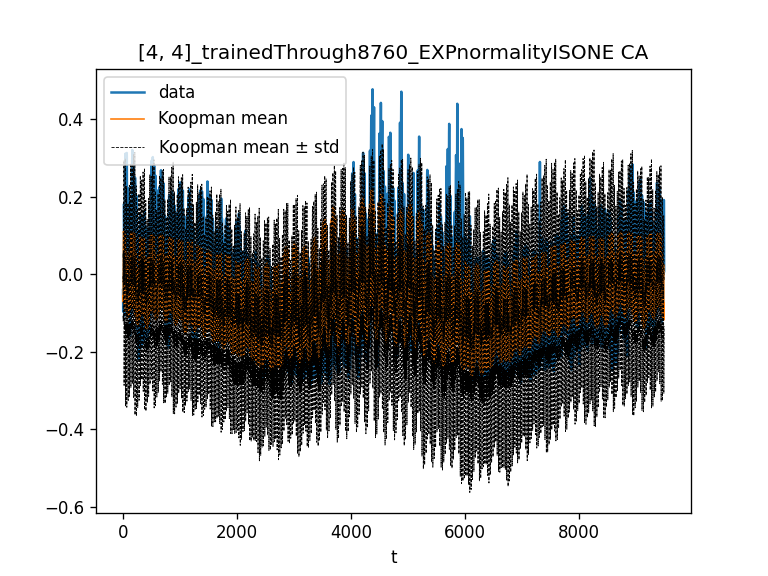

In [37]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    # plt.plot(mu_vec[slc:], label="real mu")
    # plt.plot(mu_hat[slc:, 0], label="koopman mu")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(sigma_vec[slc:], label="real sigma")
    #     plt.plot(3*sigma_hat[:, dim], label="koopman $3\sigma$", linewidth=0.7)
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [38]:
print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

actual overall mean: 0  predicted mean: -0.06984207


In [1]:
# "mean of a_hat", np.mean(a_hat), "std of a_hat", np.std(a_hat)

In [25]:
z_scores = ((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
# z_scores = ((x[train_through:predict_through] - mean_hat[train_through:]) / std_hat[train_through:])[:8760, 0]
z_hist, bin_edges = np.histogram(z_scores, bins=40, density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2

In [26]:
print("mean of z-scores:", np.mean(z_scores), "std of z-scores:", np.std(z_scores))

1.3275554227831174


-0.5732989041484382

<IPython.core.display.Javascript object>


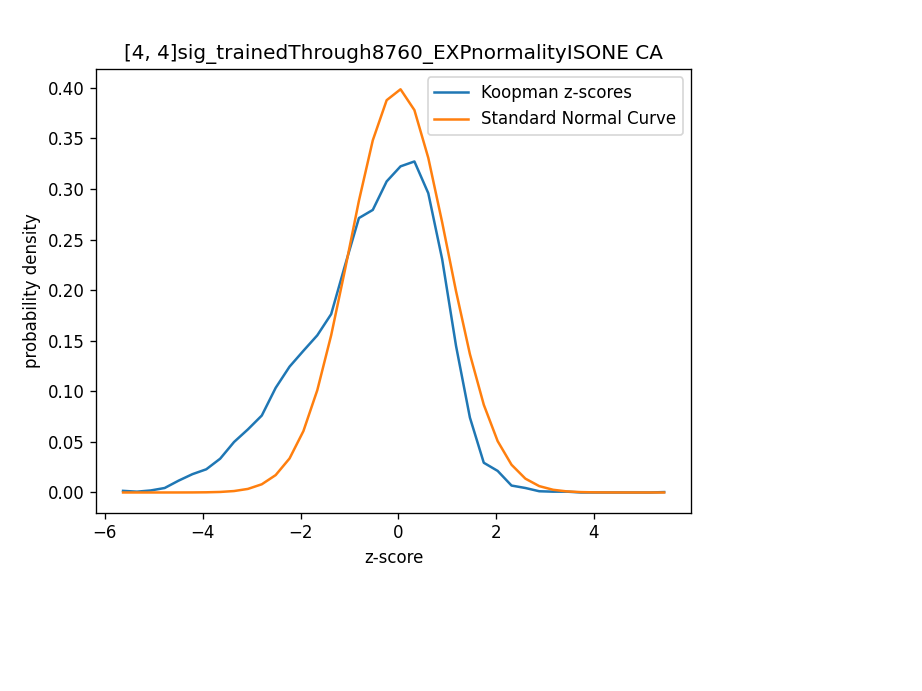

In [27]:
plt.figure()
plt.plot(z_axis, z_hist, label="Koopman z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
plt.title(f"{num_freqs}sig_trainedThrough{train_through}_" + data_name)
plt.xlabel("z-score")
plt.ylabel("probability density")
plt.legend()

In [81]:
# mu_hat -= np.mean(mean_hat[:train_through])

<IPython.core.display.Javascript object>


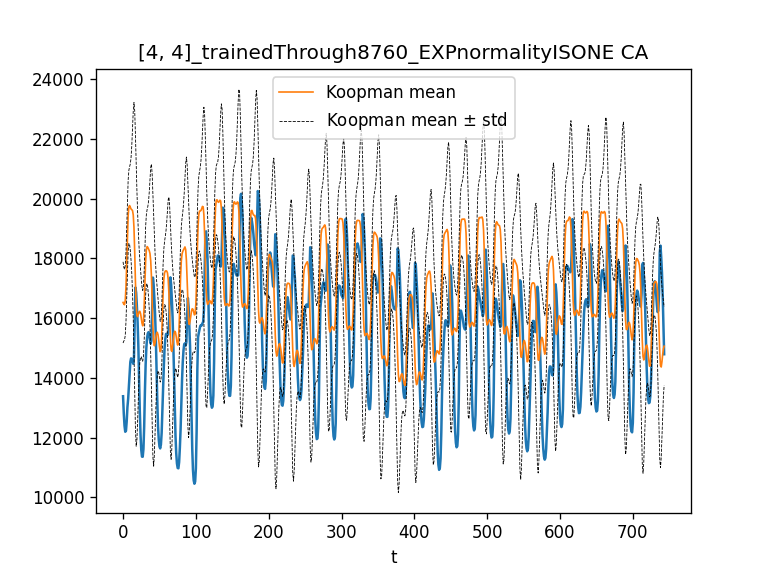

In [30]:
test_start = train_through + delay
# Skew Normal Distribution rescaling
# sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
# delta = ah / (1 + ah ** 2) ** 0.5
# muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
# muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
# sigh = sigh * rnge
# mean_hat = model.mean([muh, sigh, ah])
# std_hat = model.std([muh, sigh, ah])

# Normal Distribution
sigh = sigma_hat[test_start: predict_through] * rnge
muh = mu_hat[test_start: predict_through] * rnge + mean
mean_hat = model.mean([muh, sigh])
std_hat = model.std([muh, sigh])

plt.figure()
plt.plot(x_original[train_start:][test_start: predict_through])
plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
# plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
# plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
plt.xlabel("t")
plt.legend()
plt.show()

In [85]:
loss = normal_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh)
# loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)
print(loss)

[441.91462544]


ISONE CA
start: 2014-01-01 00:00:00
ME
start: 2014-01-01 00:00:00
RI
start: 2014-01-01 00:00:00
VT
start: 2014-01-01 00:00:00
CT
start: 2014-01-01 00:00:00
NH
start: 2014-01-01 00:00:00
SEMASS
start: 2014-01-01 00:00:00
WCMASS
start: 2014-01-01 00:00:00
NEMASSBOST
start: 2014-01-01 00:00:00
{'ISONE CA': 381.90378149175325, 'ME': 29.5225280460456, 'RI': 24.10316079531464, 'VT': 15.967894087158326, 'CT': 106.84865130851064, 'NH': 36.62805990777599, 'SEMASS': 48.63787072147622, 'WCMASS': 55.24190168505761, 'NEMASSBOST': 80.30352911316842}


In [88]:
1 - loss/vanilla_losses[zone_name]

# with 52 day gap between training and testing
# 1 - loss / 84.2  # WCMASS +25%
# 1 - loss / 122.8  # NEMASSBOST 39.4%
# 1 - loss / 596  # ISONE 19.4%
# VT: +9.2%
# (old--Monday=0) {'ISONE CA': 523.7428637110866, 'ME': 58.71157246544602, 'RI': 36.73051071209801, 'VT': 22.977155005752657, 'CT': 141.30040329213762, 'NH': 63.25224646477936, 'SEMASS': 65.42717786334023, 'WCMASS': 70.82418918073226, 'NEMASSBOST': 110.09485925971588}


array([-0.15713603])

In [68]:
import os

folder = ".\\forecasts\GEFComFirstQualTest"
a_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]alpha.npy"))
mu_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]mu.npy"))
sigma_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]sigma.npy"))

In [80]:
np.histogram?